In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

from tqdm.notebook import tqdm

import h5py

import sys
sys.path.append("..")
import models
import masks
import data


%load_ext autoreload
%autoreload 2

In [2]:
dx = 4
fs = 50

nx = 128
nx_width = 16
if dx == 20:
    nx = 32
    nx_width = 4
nt = 512

off1, off2, toff1, toff2 = masks.get_offsets(nx_width, dx=dx, fs=fs)
nt_width = toff1 + toff2 + 1 # int(np.round((nx_width-1)/m_l))
nx_stride = nx_width
nt_stride = nt_width//3

lower_res = max(nx//2 - off1, 0) 
upper_res = nx-1 - min(nx//2 + off2, nx-1)
left_res = max(nt//2 - toff1, 0)
right_res = nt-1 - min(nt//2 + toff2, nt-1)

NX = 7407
if dx == 20:
    NX = 1482
NX_pad = (NX // nx_stride) * nx_stride + nx_width - NX

model = models.CN2SUNet(1, 1, hidden_ch=32, n_layers=4).to(device)
model.load_state_dict(torch.load('../ckpt/finetuned4-complement-128x512-16x180_200.pt'))
model.eval();

In [3]:
times = ['005600', '005700', '005800', '005900',
         '010000', '010100', '010200', '010300', '010400', '010500', '010600', '010700', '010800', '010900',
         '011000', '011100']

input_mask, center_mask = masks.xmask(torch.randn(1,1,nx,nt).to(device), torch.tensor([[nx//2,nt//2]]), nx_width=nx_width, dx=dx, fs=fs)

In [ ]:
start_idx = 0

result = torch.zeros((NX, 3000))
freq = torch.zeros((NX, 3000))
pbar = tqdm(times)
for i, t in enumerate(pbar):
    
    chunk = h5py.File('../data/us7000jkbd/south30_50Hz_UTC_20230316_{}.055.h5'.format(t), 'r')['DAS'][:,81:].T
    if i < len(times) - 1:
        chunk_next = h5py.File('../data/us7000jkbd/south30_50Hz_UTC_20230316_{}.055.h5'.format(times[i+1]), 'r')['DAS'][:,81:].T
        chunk = np.concatenate([chunk, chunk_next], axis=-1)
        result = torch.cat([result,torch.zeros((NX, 3000))], dim=-1)
        freq = torch.cat([freq,torch.zeros((NX, 3000))], dim=-1)

    if dx == 20:
        chunk = chunk[::5]
    chunk = torch.from_numpy(chunk)
    chunk_pad = F.pad(chunk, (0, 0, lower_res, upper_res + NX_pad), mode='constant')
    
    while start_idx < 3000:

        pbar.set_description('idx: {}'.format(i*3000+start_idx))

        samples = chunk_pad[:, start_idx:start_idx+nt]
        if samples.shape[1] < nt:
            break
        result_tmp = torch.zeros_like(samples).to(device)
        freq_tmp = torch.zeros_like(samples).to(device)
        
        gutter = 100
        x = np.pad(samples[None,:].numpy(), ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
        x = data.bandpass(x, low=1.0, high=10.0, fs=fs, gutter=gutter)
        scale = x.std(axis=-1, keepdims=True)
        scale[scale == 0] = 1
        x = x / scale
        x = torch.from_numpy(x[0])
        
        batch = {'samples': [], 'slices': []}
        num_patches_x = (NX + NX_pad - nx_width) // nx_stride + 1
        for j in range(num_patches_x):
            sl = slice(j*nx_stride, j*nx_stride+nx)

            batch['samples'].append(x[sl])
            batch['slices'].append(sl)

        batch_samples = torch.stack(batch['samples']).unsqueeze(1).float().to(device)
        batch_samples = torch.split(batch_samples, 256)

        batch_slices = np.array(batch['slices'])
        batch_slices = [batch_slices[:256], batch_slices[256:]]
        with torch.no_grad():
            for j in range(2):
                x_in = (batch_samples[j]*input_mask).float()
                out = model(x_in) * center_mask

                for k, sl in enumerate(batch_slices[j]):
                    result_tmp[sl] += out[k,0]
                    freq_tmp[sl] += center_mask[0,0]
                    
        gutter = 100
        result_tmp = np.pad(result_tmp[None,:].cpu().numpy(), ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
        result_tmp = torch.from_numpy(data.bandpass(result_tmp, low=1.0, high=10.0, fs=50, gutter=gutter)[0].copy())
        
        result = torch.where(freq > 0, result*freq, result)
        result[:,i*3000+start_idx:i*3000+start_idx+nt] += result_tmp[lower_res:-(upper_res + NX_pad)].cpu()
        freq[:,i*3000+start_idx:i*3000+start_idx+nt] += freq_tmp[lower_res:-(upper_res + NX_pad)].cpu()
        result = torch.where(freq > 0, result/freq, result)
        
        start_idx += nt_stride
    
    start_idx = start_idx % 3000
np.save('../data/us7000jkbd_output.npy', result.cpu().numpy())

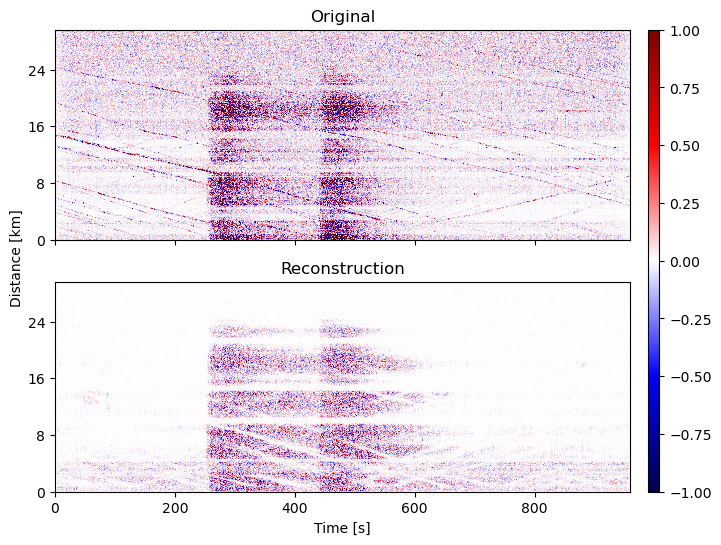

In [11]:
result = np.load('../data/us7000jkbd_output.npy')

x = np.concatenate([h5py.File('../data/us7000jkbd/south30_50Hz_UTC_20230316_{}.055.h5'.format(t), 'r')['DAS'][:,81:].T for t in times], axis=-1)
gutter = 1000
x = np.pad(x[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
x = data.bandpass(x, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]
x /= x.std(axis=-1, keepdims=True)

fig, axs = plt.subplots(2,1, sharex=True, sharey=True, figsize=(9,6))
v = 1
axs[0].imshow(x, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
im = axs[1].imshow(result, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-v, vmax=v)

axs[1].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x / 50))}'))
axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x * dx * 0.001))}'))

fig.text(0.075, 0.5, 'Distance [km]', ha='left', va='center', rotation='vertical')
axs[1].set_xlabel('Time [s]')

axs[0].set_title('Original')
axs[1].set_title('Reconstruction')

fig.colorbar(im, ax=axs, location='right', shrink=1, aspect=40, pad=0.025)
plt.savefig('./out/figure_13.pdf', bbox_inches='tight', dpi=200)
plt.show()